In [288]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt   
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D

In [289]:
data = pd.read_csv('sales_data.csv')
data.head()

,InvoiceDate,InvoiceNo,ProductID,ProductName,Category,Quantity,UnitPrice,CostPrice,CustomerID,PaymentMethod
0,2024-01-01 00:00:00.000000000,8270,128,Product_128,Toys,1,464.28,265.609823,151,Card
1,2024-01-01 08:46:07.567567567,1860,154,Product_154,Toys,7,61.64,32.576098,123,Cash
2,2024-01-01 17:32:15.135135135,6390,102,Product_102,Electronics,5,384.58,228.623401,144,Cash
3,2024-01-02 02:18:22.702702702,6191,131,Product_131,Clothing,5,210.74,111.480080,189,Card
4,2024-01-02 11:04:30.270270270,6734,109,Product_109,Books,1,331.04,183.087990,255,Online


In [290]:
data.tail()

,InvoiceDate,InvoiceNo,ProductID,ProductName,Category,Quantity,UnitPrice,CostPrice,CustomerID,PaymentMethod
995,2024-12-29 12:55:29.729729728,6232,171,Product_171,Clothing,4,51.68,26.465336,246,Cash
996,2024-12-29 21:41:37.297297296,6797,147,Product_147,Clothing,6,278.95,166.770558,161,Card
997,2024-12-30 06:27:44.864864864,5926,165,Product_165,Home,7,196.19,125.672859,200,Card
998,2024-12-30 15:13:52.432432432,7016,169,Product_169,Books,6,307.50,167.399156,216,Online
999,2024-12-31 00:00:00.000000000,4335,127,Product_127,Books,8,200.48,159.461059,212,Card


In [291]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   InvoiceDate    1000 non-null   object 
 1   InvoiceNo      1000 non-null   int64  
 2   ProductID      1000 non-null   int64  
 3   ProductName    1000 non-null   object 
 4   Category       1000 non-null   object 
 5   Quantity       1000 non-null   int64  
 6   UnitPrice      1000 non-null   float64
 7   CostPrice      1000 non-null   float64
 8   CustomerID     1000 non-null   int64  
 9   PaymentMethod  1000 non-null   object 
dtypes: float64(2), int64(4), object(4)
memory usage: 78.3+ KB


In [292]:
data.describe()

,InvoiceNo,ProductID,Quantity,UnitPrice,CostPrice,CustomerID
count,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,5594.25600,149.844000,4.944000,250.862290,162.154555,144.317000
std,2533.55383,29.239949,2.610302,140.711487,93.492524,85.461712
min,1004.00000,100.000000,1.000000,10.020000,5.616596,1.000000
25%,3467.50000,125.000000,3.000000,126.295000,82.537111,69.000000
50%,5750.00000,149.000000,5.000000,249.200000,160.069818,145.000000
75%,7806.75000,175.000000,7.000000,372.455000,236.760592,215.000000
max,9996.00000,199.000000,9.000000,499.780000,389.856307,299.000000


# Converting and simplifying the InvoiceDate column

- The `InvoiceDate` column is converted to datetime format using `pd.to_datetime()` to ensure proper date-time handling.
- A new column `InvoiceDay` is created by extracting only the date part (year, month, day) from the full datetime in `InvoiceDate`, effectively removing the time component.
- This simplifies date analysis by focusing on daily granularity instead of exact timestamps.

In [293]:
data['InvoiceDate'] = data['InvoiceDate'].apply(pd.to_datetime)  
data['InvoiceDay'] = data['InvoiceDate'].apply(lambda x: dt.datetime(x.year, x.month, x.day))  

# Setting a reference date for Recency calculation

- `pin_date` is defined as one day after the latest date in the `InvoiceDay` column.
- This date acts as a fixed "current" date or snapshot date to calculate Recency, i.e., how many days ago each customer's last purchase was made.
- Adding one day ensures the calculation includes the full last day of sales.

In [294]:
pin_date = max(data['InvoiceDay']) + dt.timedelta(1)
pin_date

Timestamp('2025-01-01 00:00:00')

# Creating new columns for sales, profit, and adjusting data types

- `sales` column is calculated as the total revenue per transaction by multiplying `Quantity` by `UnitPrice`.
- `profit` column is calculated as the profit per transaction by subtracting `CostPrice` from `UnitPrice` and multiplying by `Quantity`.
- `ProductID` column is converted to string type because it represents categorical product identifiers rather than numeric values.


In [295]:
data['sales'] = data['Quantity'] * data['UnitPrice']
data['profit'] = (data['UnitPrice'] - data['CostPrice']) * data['Quantity']
data["ProductID"] = data["ProductID"].astype(str)

In [296]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   InvoiceDate    1000 non-null   datetime64[ns]
 1   InvoiceNo      1000 non-null   int64         
 2   ProductID      1000 non-null   object        
 3   ProductName    1000 non-null   object        
 4   Category       1000 non-null   object        
 5   Quantity       1000 non-null   int64         
 6   UnitPrice      1000 non-null   float64       
 7   CostPrice      1000 non-null   float64       
 8   CustomerID     1000 non-null   int64         
 9   PaymentMethod  1000 non-null   object        
 10  InvoiceDay     1000 non-null   datetime64[ns]
 11  sales          1000 non-null   float64       
 12  profit         1000 non-null   float64       
dtypes: datetime64[ns](2), float64(4), int64(3), object(4)
memory usage: 101.7+ KB


# Visualizing the distribution of Quantity sold

- Sets the plot style to 'darkgrid' for better readability using seaborn's `set_style`.
- Uses `sns.displot` to create a histogram showing the distribution of the `Quantity` column.
- This visualization helps understand how many items are typically purchased per transaction and identifies any common purchase quantities or outliers.


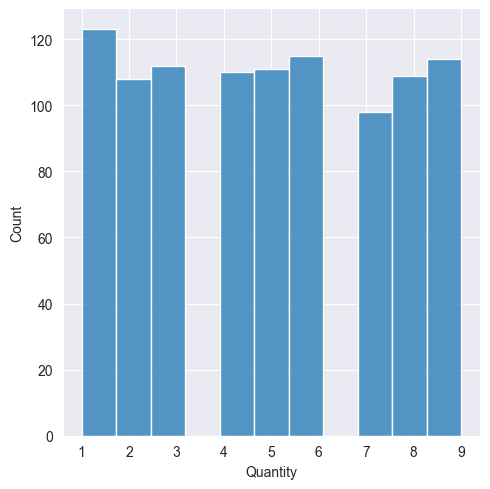

In [297]:
sns.set_style('darkgrid')
sns.displot(data['Quantity'])

# Visualizing the distribution of profit with density estimation

- Creates a histogram of the `profit` column using seaborn's `displot`.
- This helps to understand the overall distribution and shape of profit values, including common profit ranges and potential skewness.

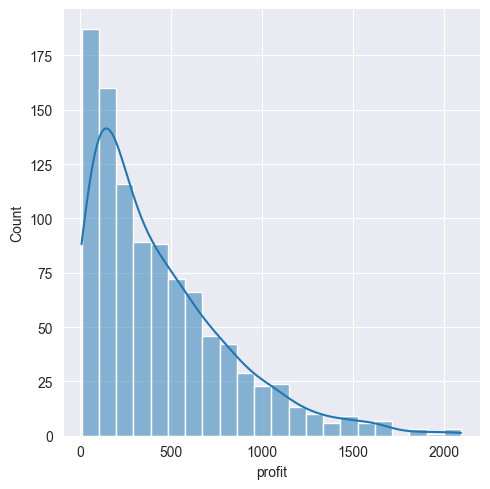

In [298]:
sns.displot(data['profit'], kde = True)

# Calculating daily total sales

- Groups the data by the `InvoiceDay` column to aggregate sales on a daily basis.
- Sums the `sales` amounts for each day using `.sum()`.
- Resets the index to convert the grouped data back to a DataFrame format.
- The resulting `daily_sales` DataFrame contains total sales for each day, useful for analyzing sales trends over time.

In [299]:
daily_sales = data.groupby("InvoiceDay")['sales'].sum().reset_index()
daily_sales

,InvoiceDay,sales
0,2024-01-01,2818.66
1,2024-01-02,2209.86
2,2024-01-03,1947.34
3,2024-01-04,840.32
4,2024-01-05,7152.95
...,...,...
361,2024-12-27,1406.39
362,2024-12-28,3535.92
363,2024-12-29,4239.23
364,2024-12-30,3218.33


# Plotting daily total quantity sold over time
- Sets the figure size to make the plot wider and more readable.
- Plots a line chart with `InvoiceDay` on the x-axis and total daily `sales` on the y-axis, marking each data point with a circle.
- Labels the x-axis as "Date" and y-axis as "Total Quantity Sold".
- Adds a title to describe the chart.
- Rotates x-axis labels by 45 degrees for better readability of date labels.
- Enables grid lines to improve visual clarity.
- Displays the plot showing trends and fluctuations in daily sales over the recorded period.

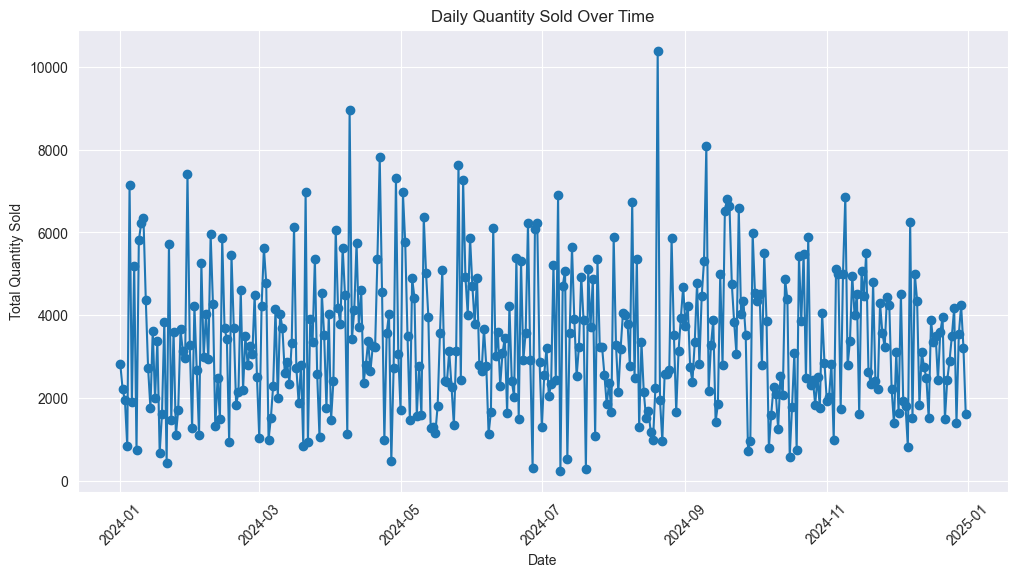

In [300]:
plt.figure(figsize=(12, 6))
plt.plot(daily_sales["InvoiceDay"], daily_sales["sales"], marker="o")
plt.xlabel("Date")
plt.ylabel("Total Quantity Sold")
plt.title("Daily Quantity Sold Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Calculating daily total profit
- Groups the dataset by `InvoiceDay` to aggregate profits for each day.
- Sums the `profit` values for all transactions occurring on the same day.
- Resets the index to convert the grouped data into a clean DataFrame.
- The resulting `daily_profit` DataFrame shows total profit generated each day, useful for analyzing profitability trends over time.

In [301]:
daily_profit = data.groupby("InvoiceDay")["profit"].sum().reset_index()
daily_profit

,InvoiceDay,profit
0,2024-01-01,1181.900489
1,2024-01-02,812.410368
2,2024-01-03,647.307361
3,2024-01-04,210.731147
4,2024-01-05,2313.010792
...,...,...
361,2024-12-27,624.398486
362,2024-12-28,1321.056431
363,2024-12-29,1516.992083
364,2024-12-30,1334.225049


# Calculating daily number of invoices (transactions)

- Groups data by the full `InvoiceDate` (including time).
- Counts the number of `InvoiceNo` entries per day, representing the number of transactions.
- Resets the index to return a DataFrame.
- The resulting `daily_nom` DataFrame shows how many transactions occurred each day, useful for understanding sales activity volume over time.


In [302]:
daily_nom = data.groupby("InvoiceDay")["InvoiceNo"].count().reset_index()
daily_nom

,InvoiceDay,InvoiceNo
0,2024-01-01,3
1,2024-01-02,3
2,2024-01-03,3
3,2024-01-04,2
4,2024-01-05,3
...,...,...
361,2024-12-27,2
362,2024-12-28,3
363,2024-12-29,3
364,2024-12-30,2


# Counting the number of sales records per product category

- This shows how many transactions are associated with each product category, helping identify the most frequently sold categories.

In [303]:
data.groupby("Category")["sales"].count().reset_index()

,Category,sales
0,Books,232
1,Clothing,193
2,Electronics,188
3,Home,183
4,Toys,204


# Calculating total profit generated by each customer
- Sums the `profit` for all transactions made by each customer.
- This helps identify which customers contribute the most to overall profit, useful for customer value analysis.

In [304]:
data.groupby("CustomerID")["profit"].sum().reset_index()

,CustomerID,profit
0,1,1786.784769
1,2,2258.772620
2,3,1627.768535
3,4,1685.784670
4,5,1074.631151
...,...,...
274,294,126.708517
275,296,1499.772261
276,297,6420.066849
277,298,901.405130


In [305]:
data['Category'].unique()

array(['Toys', 'Electronics', 'Clothing', 'Books', 'Home'], dtype=object)

# Visualizing product category distribution with a pie chart

- Calculates the count of each unique value in the `Category` column using `value_counts()`.
- Sets the figure size to a square for better pie chart aesthetics.
- Plots a pie chart showing the proportion of sales records in each product category.
- Labels each slice with the category name and shows percentage values with one decimal place.
- Starts the pie chart at 90 degrees for consistent orientation.
- Adds a title to describe the chart.
- Displays the chart to visualize the sales distribution across product categories.


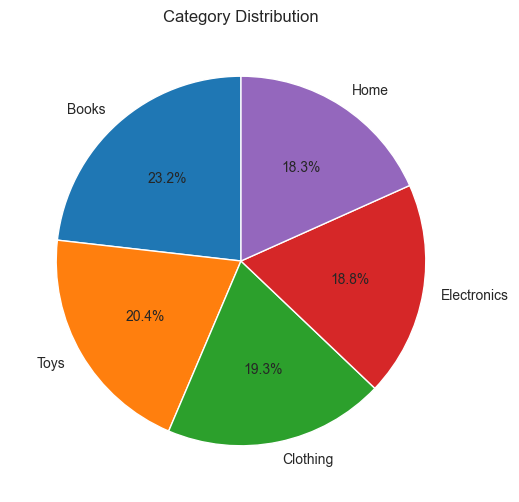

In [306]:
category_counts = data["Category"].value_counts()
plt.figure(figsize=(6,6))
plt.pie(category_counts, labels=category_counts.index, autopct="%1.1f%%", startangle=90)
plt.title("Category Distribution")
plt.show()

# Identifying the top 10 best-selling products by quantity

- Groups the dataset by `ProductName`.
- Sums the `Quantity` sold for each product to get total units sold.
- Sorts the summed quantities in descending order to find the highest sellers.
- Selects the top 10 products with the highest total quantities sold.
- The resulting `top_products` Series shows the most popular products by sales volume.


In [307]:
top_products = data.groupby("ProductName")["Quantity"].sum().sort_values(ascending=False).head(10)
top_products

ProductName
Product_197    117
Product_119     84
Product_125     75
Product_159     73
Product_186     72
Product_188     70
Product_116     69
Product_124     69
Product_175     69
Product_145     68
Name: Quantity, dtype: int64

# Visualizing the top 10 best-selling products with a horizontal bar plot

C:\Users\Sorena Pardaz\AppData\Local\Temp\ipykernel_58316\3380227322.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.values, y=top_products.index, palette="viridis")


<Axes: ylabel='ProductName'>

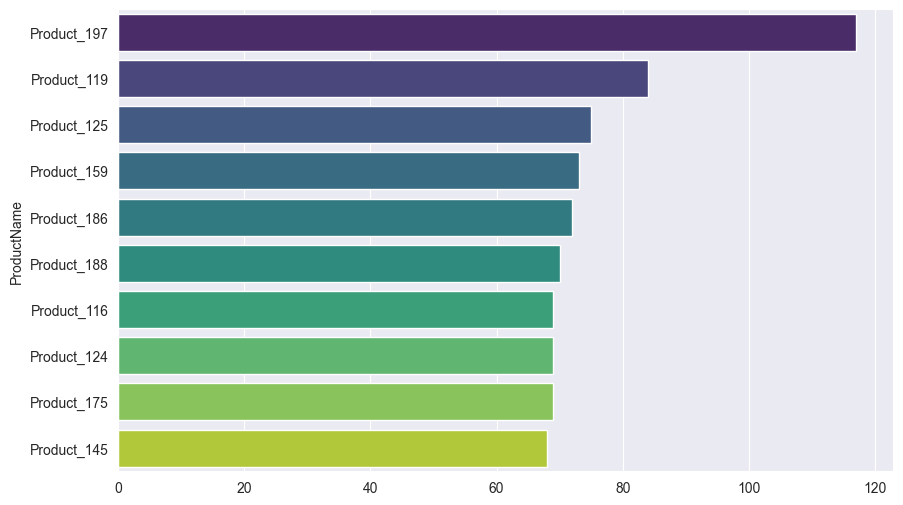

In [308]:
plt.figure(figsize=(10,6))
sns.barplot(x=top_products.values, y=top_products.index, palette="viridis")

# Calculating and displaying the sales share of the top 10 products

- Calculates the total quantity of all products sold using `data["Quantity"].sum()`.
- Sums the quantity sold of the top 10 products from `top_products`.
- Computes the percentage share of the top 10 products' quantity relative to the total quantity sold.
- Prints the result formatted to two decimal places, showing how much of total sales volume is contributed by the top products.


In [309]:
total_quantity = data["Quantity"].sum()
top_10_quantity = top_products.sum()
share = top_10_quantity / total_quantity * 100
print(f"Top 10 products account for {share:.2f}% of total quantity sold.")

Top 10 products account for 15.49% of total quantity sold.


# Calculating total profit per product category

- Groups the dataset by the `Category` column.
- Sums the `profit` for all transactions in each category.
- Sorts the categories in descending order based on total profit.
- The resulting `category_profit` Series highlights which categories generate the highest profits.


In [310]:
category_profit = data.groupby("Category")["profit"].sum().sort_values(ascending=False)
category_profit

Category
Toys           96811.264200
Books          95790.842724
Electronics    83034.063219
Home           82960.752986
Clothing       76599.466193
Name: profit, dtype: float64

# Visualizing total profit by product category with a horizontal bar plot

- Plots total profit values (`category_profit.values`) on the x-axis and category names (`category_profit.index`) on the y-axis.
- This visualization helps identify the most profitable product categories.

C:\Users\Sorena Pardaz\AppData\Local\Temp\ipykernel_58316\2990684673.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_profit.values, y=category_profit.index, palette="magma")


<Axes: ylabel='Category'>

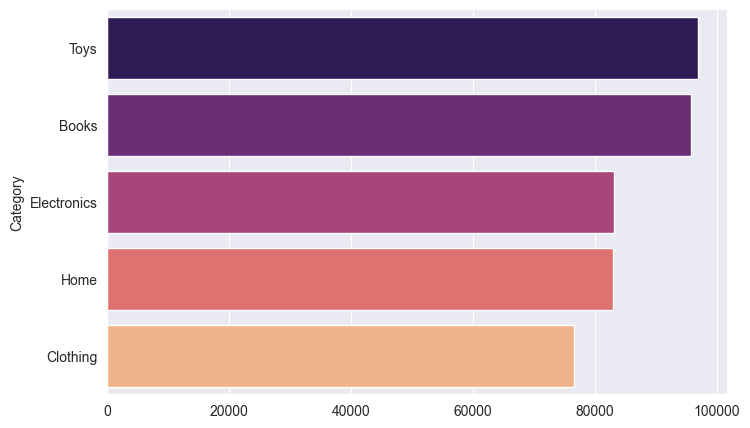

In [311]:
plt.figure(figsize=(8,5))
sns.barplot(x=category_profit.values, y=category_profit.index, palette="magma")

In [312]:
daily_sales = data.groupby('InvoiceDay')['sales'].sum().reset_index()

# Analyzing and visualizing sales by day of the week

- Creates a new column `DayOfWeek` by extracting the day name (e.g., Monday, Tuesday) from the `InvoiceDate`.
- Groups the data by `DayOfWeek` and sums the total `sales` for each day.
- Reorders the grouped sales data to follow the natural order of the week using `days_order` list.
- This helps identify which days have higher or lower sales, useful for scheduling and promotions.

<Axes: xlabel='DayOfWeek'>

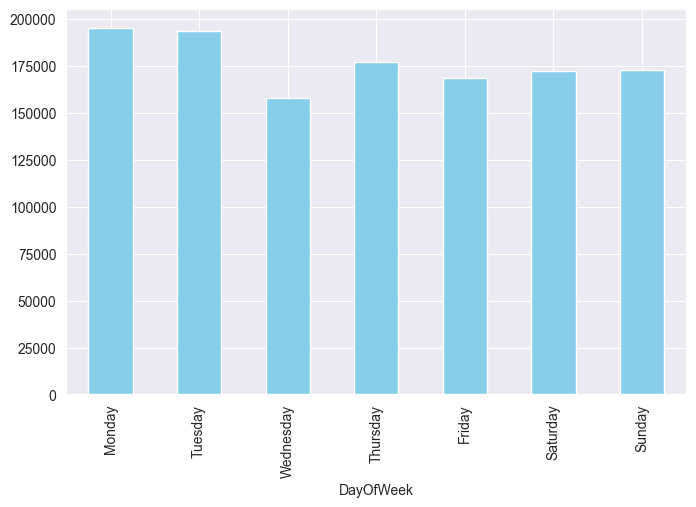

In [313]:
data['DayOfWeek'] = data['InvoiceDate'].dt.day_name()
weekly_sales = data.groupby('DayOfWeek')['sales'].sum()
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_sales = weekly_sales.reindex(days_order)
plt.figure(figsize=(8,5))
weekly_sales.plot(kind='bar', color='skyblue')

In [314]:
data.head()

,InvoiceDate,InvoiceNo,ProductID,ProductName,Category,Quantity,UnitPrice,CostPrice,CustomerID,PaymentMethod,InvoiceDay,sales,profit,DayOfWeek
0,2024-01-01 00:00:00.000000000,8270,128,Product_128,Toys,1,464.28,265.609823,151,Card,2024-01-01,464.28,198.670177,Monday
1,2024-01-01 08:46:07.567567567,1860,154,Product_154,Toys,7,61.64,32.576098,123,Cash,2024-01-01,431.48,203.447315,Monday
2,2024-01-01 17:32:15.135135135,6390,102,Product_102,Electronics,5,384.58,228.623401,144,Cash,2024-01-01,1922.90,779.782997,Monday
3,2024-01-02 02:18:22.702702702,6191,131,Product_131,Clothing,5,210.74,111.480080,189,Card,2024-01-02,1053.70,496.299601,Tuesday
4,2024-01-02 11:04:30.270270270,6734,109,Product_109,Books,1,331.04,183.087990,255,Online,2024-01-02,331.04,147.952010,Tuesday


## Calculating RFM (Recency, Frequency, Monetary) metrics for each customer

- Groups the dataset by `CustomerID` to analyze customer-level behavior.
- **Recency:** Calculates the number of days since the customer's last purchase by subtracting the most recent `InvoiceDay` from `pin_date`.
- **Frequency:** Counts the total number of invoices (`InvoiceNo`) for each customer, representing how often they made purchases.
- **Monetary:** Sums the total sales amount (`sales`) for each customer, representing the total revenue generated.
- The resulting `rfm` DataFrame summarizes these key customer metrics for further analysis.


In [315]:
rfm = data.groupby('CustomerID').agg({
    'InvoiceDay' : lambda x: (pin_date - x.max()).days,
    'InvoiceNo' : lambda x: x.count(),
    'sales' : lambda x: x.sum()
})

In [316]:
rfm

,InvoiceDay,InvoiceNo,sales
CustomerID,,,
1,8,4,5087.33
2,13,6,6591.02
3,84,4,4858.26
4,246,4,3821.20
5,231,2,2227.71
...,...,...,...
294,26,2,363.67
296,243,2,3613.14
297,37,8,16999.37


In [317]:
rfm.rename(columns={
    'InvoiceDay' : 'Recency',
    'InvoiceNo' : 'Frequency',
    'sales' : 'Monetary'
}, inplace=True)
rfm

,Recency,Frequency,Monetary
CustomerID,,,
1,8,4,5087.33
2,13,6,6591.02
3,84,4,4858.26
4,246,4,3821.20
5,231,2,2227.71
...,...,...,...
294,26,2,363.67
296,243,2,3613.14
297,37,8,16999.37


# Scoring RFM metrics using quartiles for segmentation

- Defines label ranges for each RFM metric to assign scores from 1 to 4.
- Uses `pd.qcut` to divide the `Recency` values into 4 equal-sized groups (quartiles) and assigns scores from 4 (most recent) down to 1 (least recent), since lower recency means better.
- Divides `Frequency` into quartiles and assigns scores from 1 (lowest frequency) to 4 (highest frequency).
- Similarly, divides `Monetary` values into quartiles and assigns scores from 1 (lowest spending) to 4 (highest spending).
- This scoring converts continuous RFM values into categorical segments for easier clustering and interpretation.


In [318]:
r_labels = range(4, 0, -1)
r_groups = pd.qcut(rfm['Recency'], q=4, labels=r_labels)
f_label = range(1, 5)
f_groups = pd.qcut(rfm['Frequency'], q=4, labels=f_label)
m_label = range(1, 5)
m_groups = pd.qcut(rfm['Monetary'], q=4, labels=m_label)

# Adding R, F, and M scores to the RFM DataFrame

- Assigns the Recency (`R`) scores obtained from `r_groups` to a new column `R` in the `rfm` DataFrame.
- Assigns the Frequency (`F`) scores from `f_groups` to the column `F`.
- Assigns the Monetary (`M`) scores from `m_groups` to the column `M`.
- These columns represent the quartile-based scores for each RFM metric, preparing the data for clustering and segmentation.

In [319]:
rfm['R'] = r_groups.values
rfm['F'] = f_groups.values
rfm['M'] = m_groups

In [320]:
rfm.sample(20)

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
203,200,2,4622.28,1,1,3
108,243,4,7397.75,1,3,4
1,8,4,5087.33,4,3,3
13,7,4,3508.32,4,3,2
242,61,3,1547.05,3,2,1
189,186,4,5437.80,1,3,3
131,43,2,1681.39,3,1,1
277,246,3,2342.11,1,2,2
184,229,2,648.55,1,1,1


In [321]:
rfm.dtypes

Recency         int64
Frequency       int64
Monetary      float64
R            category
F            category
M            category
dtype: object

In [322]:
rfm = rfm.astype({'R': 'int', 'F': 'int', 'M': 'int'})

# Creating a combined RFM group code

- Concatenates the `R`, `F`, and `M` scores (after converting them to strings) for each customer.
- Stores the result in a new column `RFMGroup`.

In [323]:
rfm['RFMGroup'] = rfm.R.map(str) + rfm.F.map(str) + rfm.M.map(str)

In [324]:
rfm

,Recency,Frequency,Monetary,R,F,M,RFMGroup
CustomerID,,,,,,,
1,8,4,5087.33,4,3,3,433
2,13,6,6591.02,4,4,4,444
3,84,4,4858.26,2,3,3,233
4,246,4,3821.20,1,3,2,132
5,231,2,2227.71,1,1,1,111
...,...,...,...,...,...,...,...
294,26,2,363.67,4,1,1,411
296,243,2,3613.14,1,1,2,112
297,37,8,16999.37,3,4,4,344


In [325]:
rfm['RFMScore'] = rfm[['R', 'F', 'M']].sum(axis=1)

# Categorizing customers into loyalty levels based on RFM score

- Defines a list of loyalty levels: `Platinum`, `Gold`, `Silver`, and `Bronze`.
- Assigns one of the loyalty levels to each customer based on which quantile their score falls into.
- This creates a qualitative measure of customer value, making segmentation easier to interpret.


In [326]:
loyalty_level = ['Platinum', 'Gold', 'Silver', 'Bronze']
Score_cuts = pd.qcut(rfm.RFMScore, q=4, labels=loyalty_level)

In [327]:
rfm['RFM_loyalty_level'] = Score_cuts.values
rfm.reset_index().head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_loyalty_level
0,1,8,4,5087.33,4,3,3,433,10,Silver
1,2,13,6,6591.02,4,4,4,444,12,Bronze
2,3,84,4,4858.26,2,3,3,233,8,Silver
3,4,246,4,3821.20,1,3,2,132,6,Gold
4,5,231,2,2227.71,1,1,1,111,3,Platinum


# Visualizing the number of customers by loyalty level
- This chart helps quickly see how many customers belong to each loyalty segment.

<Axes: xlabel='RFM_loyalty_level', ylabel='count'>

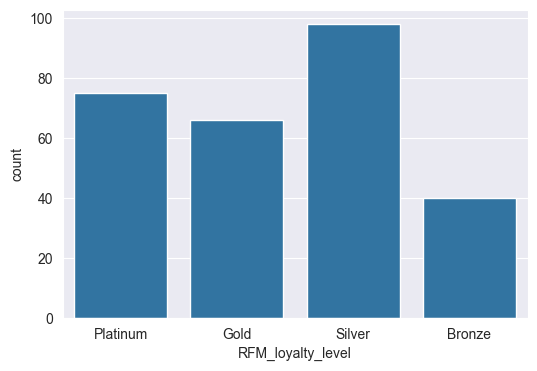

In [328]:
plt.figure(figsize=(6,4))
sns.countplot(x='RFM_loyalty_level', data=rfm, order=['Platinum','Gold','Silver','Bronze'])

# Extracting and displaying VIP (Platinum) customers

- Filters the `rfm` DataFrame to select only customers whose `RFM_loyalty_level` is **Platinum**.  
- This allows a quick look at the most valuable customers based on their RFM score.

In [329]:
vip_customers = rfm[rfm['RFM_loyalty_level'] == 'Platinum']
vip_customers.head()

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_loyalty_level
CustomerID,,,,,,,,,
5,231,2,2227.71,1,1,1,111,3,Platinum
6,158,1,1134.24,1,1,1,111,3,Platinum
8,101,1,1759.52,2,1,1,211,4,Platinum
14,167,2,4684.26,1,1,3,113,5,Platinum
19,291,3,2056.77,1,2,1,121,4,Platinum


# Calculating the average R, F, and M scores for each loyalty level
- This table provides insights into how Recency, Frequency, and Monetary values differ across loyalty levels.


In [330]:
rfm.groupby('RFM_loyalty_level')[['R', 'F', 'M']].mean().round(2)

C:\Users\Sorena Pardaz\AppData\Local\Temp\ipykernel_58316\3498573045.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rfm.groupby('RFM_loyalty_level')[['R', 'F', 'M']].mean().round(2)


,R,F,M
RFM_loyalty_level,,,
Platinum,1.41,1.15,1.48
Gold,2.33,2.12,2.00
Silver,2.97,3.07,3.03
Bronze,3.72,3.92,3.92


# Performing KMeans clustering on RFM scores
- Fits the KMeans model to the RFM data, partitioning customers into 5 distinct clusters based on their Recency, Frequency, and Monetary scores.

In [331]:
X = rfm[['R', 'F', 'M']]
k_means = KMeans(n_clusters=5, init='k-means++', max_iter=300, random_state=42)
k_means.fit(X)

,n_clusters,5
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [332]:
rfm['kmeans_cluster'] = k_means.labels_

In [333]:
rfm

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_loyalty_level,kmeans_cluster
CustomerID,,,,,,,,,,
1,8,4,5087.33,4,3,3,433,10,Silver,3
2,13,6,6591.02,4,4,4,444,12,Bronze,3
3,84,4,4858.26,2,3,3,233,8,Silver,4
4,246,4,3821.20,1,3,2,132,6,Gold,4
5,231,2,2227.71,1,1,1,111,3,Platinum,0
...,...,...,...,...,...,...,...,...,...,...
294,26,2,363.67,4,1,1,411,6,Gold,1
296,243,2,3613.14,1,1,2,112,4,Platinum,0
297,37,8,16999.37,3,4,4,344,11,Bronze,3


# Converting RFM score columns to integer type

- Changes the data type of the `R`, `F`, and `M` columns to `int64`.
- This ensures that the RFM scores are stored as integers instead of categorical or float types.
- Integer conversion is useful for cleaner representation and easier interpretation in further analysis and clustering.

In [334]:
rfm[['R', 'F', 'M']] = rfm[['R', 'F', 'M']].astype('int64')

In [347]:
rfm.dtypes

Recency                 int64
Frequency               int64
Monetary              float64
R                       int64
F                       int64
M                       int64
RFMGroup                int32
RFMScore                int64
RFM_loyalty_level    category
kmeans_cluster          int32
RFMGroup_numeric        int32
dtype: object

In [346]:
rfm['RFMGroup'] = pd.to_numeric(rfm['RFMGroup'], errors='coerce')

In [344]:
rfm2 = rfm.drop('RFM_loyalty_level', axis=1)

In [345]:
rfm2.dtypes

Recency               int64
Frequency             int64
Monetary            float64
R                     int64
F                     int64
M                     int64
RFMGroup              int32
RFMScore              int64
kmeans_cluster        int32
RFMGroup_numeric      int32
dtype: object

In [349]:
rfm2[rfm2['kmeans_cluster'] == 4].mean()

Recency              131.685714
Frequency              4.371429
Monetary            4466.160571
R                      1.600000
F                      3.314286
M                      2.571429
RFMGroup             195.714286
RFMScore               7.485714
kmeans_cluster         4.000000
RFMGroup_numeric     195.714286
dtype: float64

In [350]:
rfm2.mean()

Recency               93.784946
Frequency              3.584229
Monetary            4429.493011
R                      2.508961
F                      2.451613
M                      2.498208
RFMGroup             277.910394
RFMScore               7.458781
kmeans_cluster         1.899642
RFMGroup_numeric     277.910394
dtype: float64

In [ ]:
k_means.inertia_

291.4920021780472

# Finding the optimal number of clusters using the Elbow Method

- Initializes an empty dictionary `wcss` to store the Within-Cluster Sum of Squares (WCSS) for different cluster numbers.
- Iterates through cluster values from 1 to 14:
  - For each `k`, runs KMeans clustering with the specified number of clusters.
  - Fits the model to the RFM data (`X`) and stores the inertia (WCSS) in the dictionary.
- Plots the WCSS values against the number of clusters using a point plot.
- The resulting curve helps identify the 'elbow point', where increasing the number of clusters yields diminishing returns, indicating the optimal cluster count.

<Axes: >

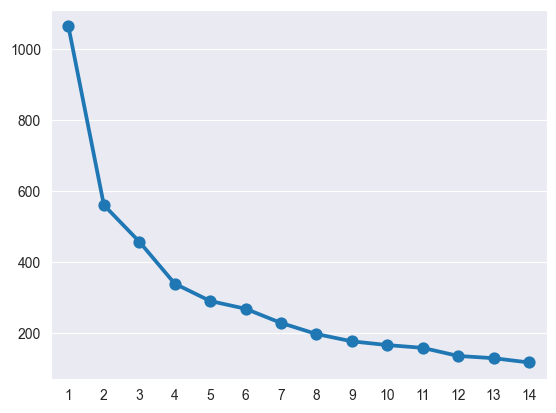

In [ ]:
wcss = {}
for k in range(1, 15):
    k_means = KMeans(n_clusters=k, init='k-means++', max_iter=300, random_state=42)
    k_means.fit(X)
    wcss[k] = k_means.inertia_

sns.pointplot(x=list(wcss.keys()), y=list(wcss.values()))

In [ ]:
cluster_summary = rfm.groupby('kmeans_cluster')[['Recency','Frequency','Monetary']].mean().round(2)
(cluster_summary)

,Recency,Frequency,Monetary
kmeans_cluster,,,
0,179.65,1.82,1835.15
1,26.60,3.34,2714.10
2,105.66,2.57,4489.57
3,40.49,5.33,7407.28
4,131.69,4.37,4466.16


# Visualizing customer clusters in 3D based on RFM scores

- Creates a 3D scatter plot to display customer clusters using their R, F, and M scores.
- Each point represents a customer, and colors correspond to different KMeans clusters (`kmeans_cluster`).
- The x, y, and z axes represent Recency (R), Frequency (F), and Monetary (M) scores respectively.
- Adds axis labels and a title for clarity.
- Includes a colorbar to indicate which colors correspond to which cluster IDs.
- This visualization helps observe how customers are distributed across clusters in three dimensions.

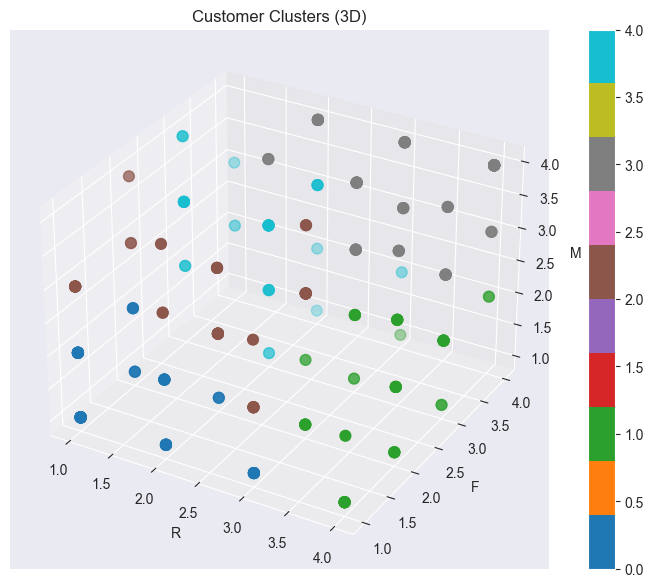

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    rfm['R'], rfm['F'], rfm['M'],
    c=rfm['kmeans_cluster'], cmap='tab10', s=60
)

ax.set_xlabel('R')
ax.set_ylabel('F')
ax.set_zlabel('M')
ax.set_title('Customer Clusters (3D)')
plt.colorbar(scatter)
plt.show()


# Summarizing average RFM values for each customer cluster

- Groups the `rfm` DataFrame by `kmeans_cluster` to analyze clusters separately.
- Calculates the mean `Recency`, `Frequency`, and `Monetary` for customers in each cluster.
- Renames columns (though `CustomerID` rename is unused here).
- Rounds the resulting values to two decimal places for cleaner display.
- Sorts the summary by `Monetary` in descending order to show clusters with the highest spending first.
- Prints the final summary table, which provides an overview of the characteristics of each cluster.

In [ ]:
summary = rfm.groupby('kmeans_cluster').agg({
    'Recency': lambda x: x.mean(),
    'Frequency': lambda x: x.mean(),
    'Monetary': lambda x: x.mean()
}).rename(columns={'CustomerID': 'Num_Customers'}).round(2)

summary = summary.sort_values(by='Monetary', ascending=False)
print(summary)

                Recency  Frequency  Monetary
kmeans_cluster                              
3                 40.49       5.33   7407.28
2                105.66       2.57   4489.57
4                131.69       4.37   4466.16
1                 26.60       3.34   2714.10
0                179.65       1.82   1835.15


In [ ]:
dbscan = DBSCAN(eps=0.7, min_samples=3)
dbscan.fit(X)

,eps,0.7
,min_samples,3
,metric,'euclidean'
,metric_params,None
,algorithm,'auto'
,leaf_size,30
,p,None
,n_jobs,None


In [ ]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35], dtype=int64)

In [ ]:
silhouette_score(X, dbscan.labels_)

0.8414242890876313